In [22]:
import json

from web3 import Web3
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt
import bisect

# Import python dotenv
from dotenv import load_dotenv
import numpy as np
import os

from operator import itemgetter

# Import mongodb client
from pymongo import MongoClient, UpdateOne, DESCENDING, ASCENDING, InsertOne, DeleteOne

from multiprocessing.pool import Pool
from functools import reduce
from tqdm import tqdm, trange

In [3]:

load_dotenv()
# Connect to local node
w3 = Web3(Web3.HTTPProvider('http://localhost:8545'))


# Connect to mongodb
client = MongoClient(os.getenv("MONGO_URI"))

# Get database
mempool = client.transactions.mempool

mempool.estimated_document_count()

376042

In [43]:
# What's the oldest transaction we have from the mempool?
tx_hash = mempool.find_one(sort=[("timestamp", ASCENDING)])["hash"]

# Get the block number of the oldest transaction
block_number = w3.eth.get_transaction(tx_hash)["blockNumber"]

block_number

17495345

In [13]:
# Get the {limit} most recent transactions
limit = 100_000
mempool_transactions = mempool.find(sort=[('ts', DESCENDING)], limit=limit)
mempool_transactions = list(tqdm(mempool_transactions, total=limit))

  0%|          | 0/100000 [00:00<?, ?it/s]

In [5]:
cols_of_interest = [
    'hash',
    'ts',
    'gasPrice',
    'routerContract',
    'value',
    'from',
    'to',
]

# Convert to dataframe
df = pd.DataFrame(mempool_transactions)
print(df.columns)
print(df.shape)
df = df[cols_of_interest]
df.head()

Index(['_id', 'hash', 'type', 'accessList', 'blockHash', 'blockNumber',
       'transactionIndex', 'confirmations', 'from', 'gasPrice',
       'maxPriorityFeePerGas', 'maxFeePerGas', 'gasLimit', 'to', 'value',
       'nonce', 'data', 'r', 's', 'v', 'creates', 'chainId', 'routerContract',
       'ts', 'timestamp', 'gasPriceRaw', 'gasLimitRaw', 'toChecksummed',
       'totalTransactionsSeen', 'uniswapTransactionCount',
       'uniswapShareOfTotal', 'formattedDate'],
      dtype='object')
(100000, 32)


,hash,ts,gasPrice,routerContract,value,from,to
0,0x9b3e2578c470bb0a7d7a1df7cccded35a7ef174fea10...,2023-06-23 19:18:18.678,30.318008,UniversalRouter02,"{'_hex': '0x04ce2006a1261f54', '_isBigNumber':...",0x3361475AD16dFb56367755C103475c2d02d53938,0x3fC91A3afd70395Cd496C647d5a6CC9D4B2b7FAD
1,0x32d5dca77e51b3ea1434aae97a28aa70a3c0de97bf6e...,2023-06-23 19:18:17.122,22.746484,UniversalRouter02,"{'_hex': '0x00', '_isBigNumber': True}",0xc282d549e106FDeA2f2635466548192E161C261e,0x3fC91A3afd70395Cd496C647d5a6CC9D4B2b7FAD
2,0xb908fcb9a21030f7aebffec049091c015e6f1608610e...,2023-06-23 19:18:16.604,29.277980,UniversalRouter02,"{'_hex': '0x0853a0d2313c0000', '_isBigNumber':...",0x4e477e060E1404fcec97f08FF5Be05b869c1DAed,0x3fC91A3afd70395Cd496C647d5a6CC9D4B2b7FAD
3,0x45126ebc803f8c53ba80fbd9b2eb6a1e5bc4d0b3479d...,2023-06-23 19:18:16.209,52.000000,UniswapV2Router02,"{'_hex': '0x044d575b885f0000', '_isBigNumber':...",0x8F8097A2aF8EcB317f05ff284069afaA87763952,0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D
4,0x3b89206a0a5ddc05a9f086b9d814d75968f60f7f65bc...,2023-06-23 19:18:15.777,26.935982,UniversalRouter02,"{'_hex': '0x01d300bcd11635d2', '_isBigNumber':...",0x9c22cebB76ed68d241e2515D3fC0B0500C7Cb4b7,0x3fC91A3afd70395Cd496C647d5a6CC9D4B2b7FAD


In [6]:
# Find the oldest timestamp in the list of transactions
oldest_ts = df['ts'].min()

oldest_ts

Timestamp('2023-06-22 17:27:04.392000')

In [7]:
# Get latest block
latest_block = w3.eth.get_block('latest')

assert latest_block and 'number' in latest_block

blocknumber = latest_block['number']

In [9]:
# Iterate backwards from latest block to oldest block until we find the block that is older than the oldest transaction in the mempool
blocknumber = bisect.bisect_right(list(range(0, blocknumber)), oldest_ts.timestamp(), key=lambda x: w3.eth.get_block(x)['timestamp'])

blocknumber, datetime.fromtimestamp(w3.eth.get_block(blocknumber)['timestamp'])

(17536636, datetime.datetime(2023, 6, 22, 17, 27, 11))

In [10]:
# Get all transactions in all blocks from `blocknumber` to `latest_block`

# Guardrail
assert latest_block and 'number' in latest_block

block_transactions = []
blocks = []
for i in trange(blocknumber, latest_block['number'] + 1):
    block = w3.eth.get_block(i)
    blocks.append(block)
    if not 'transactions' in block:
        continue

    for tx in block['transactions']:
        block_transactions.append(Web3.to_hex(tx))


print(f"Found {len(block_transactions):,} transactions in {len(blocks):,} blocks")

  0%|          | 0/7665 [00:00<?, ?it/s]

Found 1,136,638 transactions in 7,665 blocks


In [25]:
# Print example transactions hashes
block_transactions[:5]

['0xadcab3d7876583ee95b5b2c85a022ab6793fcd52b57463ca125d537ad1b700c7',
 '0xa963ce2e76e4a1a44165a1bd4ee945aa49c7c013ed106770ad915a65b6be9c63',
 '0xdbb21a39a3bae4daa8907860815a4d521c0044f5d5eb60a7a380e69f97a1304a',
 '0x31044094bc7c132084fb8664f3085a26766c6718f87d695e0f32b8cd64ea55dd',
 '0x5803bc81c33f6b7f69411d4858fb0d2870a4676ad8d6c1b6924f0d8cd1ed3040']

In [27]:
# Load in the router addresses from the router_addresses.json file
with open('addresses/router_addresses.json', 'r') as f:
    router_addresses = json.load(f)

router_addresses

{'0xf164fC0Ec4E93095b804a4795bBe1e041497b92a': 'UniswapV2Router01',
 '0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D': 'UniswapV2Router02',
 '0xE592427A0AEce92De3Edee1F18E0157C05861564': 'UniswapV3Router01',
 '0x68b3465833fb72A70ecDF485E0e4C7bD8665Fc45': 'UniswapV3Router02',
 '0xEf1c6E67703c7BD7107eed8303Fbe6EC2554BF6B': 'UniversalRouter01',
 '0x3fC91A3afd70395Cd496C647d5a6CC9D4B2b7FAD': 'UniversalRouter02'}

In [29]:
# Filter out transactions that are not from the router contracts
router_transactions = []

for tx in tqdm(block_transactions):
    tx = w3.eth.get_transaction(tx)
    if 'to' in tx and tx['to'] in router_addresses and 'hash' in tx:
        tx = {**tx, 'routerContract': router_addresses[tx['to']], 'hash': w3.to_hex(tx['hash'])}
        router_transactions.append(tx)

len(router_transactions)

  1%|▏         | 15222/1174164 [00:49<1:02:38, 308.35it/s]


KeyboardInterrupt: 

In [101]:
router_transactions[1]

{'blockHash': HexBytes('0x61e2d52aff99822c9006fb6a4648bb1288f9635863dd2fcf8dda7e704c8939d4'),
 'blockNumber': 17537194,
 'from': '0x9D320B140b00e42BA91aeC926D4C75858d4e2129',
 'gas': 232842,
 'gasPrice': 16353842006,
 'maxFeePerGas': 24083780453,
 'maxPriorityFeePerGas': 100000000,
 'hash': '0x87100b6460dd86c1473ac9c0a3177c05db06272be0eefad29d0c0aa7b938a16a',
 'input': '0x3593564c000000000000000000000000000000000000000000000000000000000000006000000000000000000000000000000000000000000000000000000000000000a0000000000000000000000000000000000000000000000000000000006494a5cf00000000000000000000000000000000000000000000000000000000000000030a080c00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000003000000000000000000000000000000000000000000000000000000000000006000000000000000000000000000000000000000000000000000000000000001e0000000000000000000000000000000000000000000000000000000000000030000000000000000000000000000000000000000000

In [28]:
# Put all the transaction hashes in a set for both sets of transactions
block_transaction_set = set(map(itemgetter('hash'), router_transactions))
mempool_transactions = set(df['hash'])

# Find the intersection and the symmetric difference of the two sets
intersection = block_transaction_set.intersection(mempool_transactions)
symmetric_difference = block_transaction_set.symmetric_difference(mempool_transactions)

print(f"Block: {len(block_transaction_set)}, Mempool: {len(mempool_transactions)}, Intersection: {len(intersection)}, Symmetric Difference: {len(symmetric_difference)}")

NameError: name 'router_transactions' is not defined

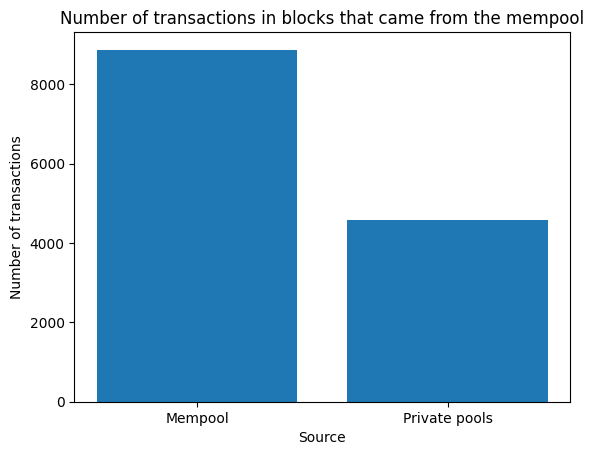

In [98]:
# Make a bar chart showing:
# - The number of transactions in blocks that came from the mempool
# - The number of transactions in blocks that did not come from the mempool

plt.bar(['Mempool', 'Private pools'], [len(intersection), len(block_transaction_set - mempool_transactions)])
plt.xlabel('Source')
plt.ylabel('Number of transactions')
plt.title('Number of transactions in blocks that came from the mempool');

### What kind of transaction did not make it to the blocks

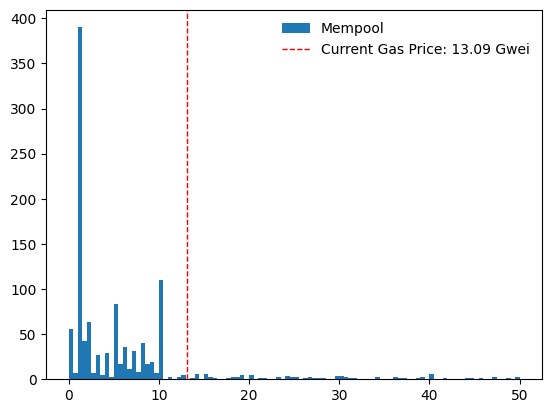

In [78]:
# Make a dataframe of the transactions that are in the mempool but not in the blocks
mempool_bad_transactions = df[df['hash'].isin(symmetric_difference)]

# Plot histogram of gas prices limited to 50 gwei
plt.hist(mempool_bad_transactions['gasPrice'], bins=100, range=(0, 50), label='Mempool')

# Add vertical line for the current gas price converted to gwei
curr_gas_price = w3.eth.gas_price / 1e9
plt.axvline(curr_gas_price, color='red', linestyle='dashed', linewidth=1, label=f"Current Gas Price: {curr_gas_price:.2f} Gwei")
plt.legend(frameon=False);

### Histogram over the gas price for all transactions that made it to the blocks

In [ ]:
# Plot histogram of gas prices limited to 50 gwei

### Plot histogram over the gas price for all blocks collected

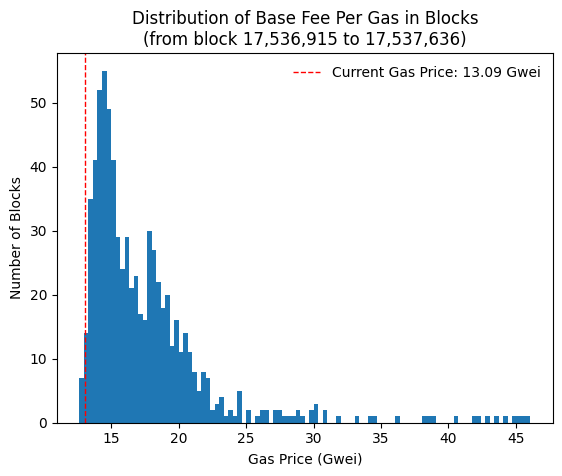

In [100]:
block_gas_prices = []

for block in blocks:
    block_gas_prices.append(block['baseFeePerGas'] / 1e9)

plt.hist(block_gas_prices, bins=100)
plt.axvline(curr_gas_price, color='red', linestyle='dashed', linewidth=1, label=f"Current Gas Price: {curr_gas_price:.2f} Gwei")
plt.xlabel('Gas Price (Gwei)')
plt.ylabel('Number of Blocks')
plt.title(f'Distribution of Base Fee Per Gas in Blocks\n(from block {blocknumber:,} to {latest_block["number"]:,})')
plt.legend(frameon=False);

## Decoding the transactions Uniswap transactions from the blocks

In [14]:
# Load in the ABIs
with open('abi/UniswapV3Pool.json', 'r') as f:
    uniswap_v3_pool_abi = json.load(f)

with open('abi/UniswapV2Pair.json', 'r') as f:
    uniswap_v2_pair_abi = json.load(f)

In [15]:
def liquidity_events(tx_hash):
    # Get transaction receipt
    tx_receipt = w3.eth.get_transaction_receipt(tx_hash)

    liquidity_events = []
    events = ["Swap", "Mint", "Burn"]
    abis = [uniswap_v2_pair_abi, uniswap_v3_pool_abi]

    for log in tx_receipt['logs']:
        # Try to parse the log using both V2 and V3 contract ABI\

        for abi in abis:
            contract = w3.eth.contract(abi=abi, address=log['address'])
        
        
            # Parse the logs for Swap, Mint, and Burn events
            for event in events:
                try:
                    event_data = getattr(contract.events, event)().process_log(log)
                except:
                    continue

                liquidity_events.append(event_data)

    return liquidity_events

In [28]:
limit = 100_000
n_chunks = 6

In [36]:
%%time
# Define the function to be used in a separate process
def process_chunk(chunk):
    all_events = []
    for tx in tqdm(chunk):
        all_events += liquidity_events(tx)
    return all_events

# Split the data into 4 chunks
chunks = np.array_split(block_transactions[:limit], n_chunks)

# Create a pool of processes
with Pool(processes=n_chunks) as pool:
    # Use the pool's map method to assign each chunk to a separate process
    result = pool.map(process_chunk, chunks)

# Combine the results from each process into a single list
all_events = [event for sublist in result for event in sublist]

100%|██████████| 16667/16667 [29:25<00:00,  9.44it/s]


In [37]:
df = pd.DataFrame([{'UniswapVersion': 'V3' if 'sqrtPriceX96' in event.args else 'V2', 'Event': event.event} for event in all_events])

df.groupby("UniswapVersion").Event.value_counts()

UniswapVersion  Event
V2              Swap     16485
                Mint       440
                Burn       194
V3              Swap      5536
Name: count, dtype: int64

In [39]:
"0x819bc29517ade878e3c5b4d85a19b189c2aa1abe7a545447adfff77a35eeff2f" in block_transactions[:limit]

False